##### How can user review/feedback be effectively grouped to identify key areas for app improvement? / Can we Identify common technical issues and feature request based on user reviews to improve the application user experience?

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [38]:
df = pd.read_csv('gcash-2023-formatted.csv')

In [39]:
df.head()

,Unnamed: 0.1,Unnamed: 0,review_text,review_rating,review_datetime_utc,review_likes,review_text_formatted
0,454629,454629,"When I open my g-cash, I got to choose later &...",1,2023-01-01T00:41:06.000Z,0,"['open', 'gcash', 'get', 'choose', 'late', 'tr..."
1,454631,454631,Stupid app i used my original psa but they tol...,1,2023-01-01T01:46:15.000Z,0,"['stupid', 'application', 'use', 'original', '..."
2,454632,454632,app keeps disappearing,1,2023-01-01T02:07:54.000Z,0,"['application', 'keep', 'disappearing']"
3,454635,454635,Good but I can't dl it anymore why?,5,2023-01-01T02:22:04.000Z,0,"['good', 'negativelabel', 'download', 'anymore']"
4,454637,454637,Lage nawawala sa cp ko di ko.alam kung bakit.,1,2023-01-01T02:31:29.000Z,0,"['palagi', 'nawawala', 'phone', 'alam']"


# Data Pre-Processing

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81387 entries, 0 to 81386
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0.1           81387 non-null  int64 
 1   Unnamed: 0             81387 non-null  int64 
 2   review_text            81387 non-null  object
 3   review_rating          81387 non-null  int64 
 4   review_datetime_utc    81387 non-null  object
 5   review_likes           81387 non-null  int64 
 6   review_text_formatted  81387 non-null  object
dtypes: int64(4), object(3)
memory usage: 4.3+ MB


In [41]:
print(df.isna().sum())

Unnamed: 0.1             0
Unnamed: 0               0
review_text              0
review_rating            0
review_datetime_utc      0
review_likes             0
review_text_formatted    0
dtype: int64


In [42]:
print(df['review_rating'].value_counts())

review_rating
1    51394
5    14538
2     7207
3     5290
4     2958
Name: count, dtype: int64


In [43]:
df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0','review_datetime_utc', 'review_text'], inplace=True)
df.dropna(inplace=True)

In [44]:
df.head()

,review_rating,review_likes,review_text_formatted
0,1,0,"['open', 'gcash', 'get', 'choose', 'late', 'tr..."
1,1,0,"['stupid', 'application', 'use', 'original', '..."
2,1,0,"['application', 'keep', 'disappearing']"
3,5,0,"['good', 'negativelabel', 'download', 'anymore']"
4,1,0,"['palagi', 'nawawala', 'phone', 'alam']"


In [45]:
import re

df['review_text_formatted'] = df['review_text_formatted'].apply(
    lambda x: re.sub(r"[\[\]']", '', x)  # Removes [, ], and ' characters
)

df['review_text_formatted'] = df['review_text_formatted'].apply(
    lambda x: x.replace(',', '') if isinstance(x, str) else x
)

In [46]:
df.head()

,review_rating,review_likes,review_text_formatted
0,1,0,open gcash get choose late try gcash icon auto...
1,1,0,stupid application use original psa tell verif...
2,1,0,application keep disappearing
3,5,0,good negativelabel download anymore
4,1,0,palagi nawawala phone alam


In [47]:
print(df.duplicated(subset=['review_text_formatted']).sum())
df = df.drop_duplicates(subset=['review_text_formatted'])

5895


# Exploratory Data Analysis

Top 20 Most Frequent Words in Reviews

In [48]:
word_list = df['review_text_formatted'].str.split().explode()  # Flatten tokenized words
word_freq = Counter(word_list)

# View top 20 words
print(word_freq.most_common(20))

[('negativelabel', 52971), ('application', 32507), ('gcash', 25758), ('update', 19336), ('open', 11619), ('account', 10806), ('money', 10477), ('use', 10186), ('always', 9459), ('need', 7914), ('verify', 6875), ('ninyo', 6530), ('please', 6482), ('fix', 6116), ('time', 6087), ('good', 5609), ('even', 5358), ('say', 5285), ('keep', 4932), ('login', 4800)]


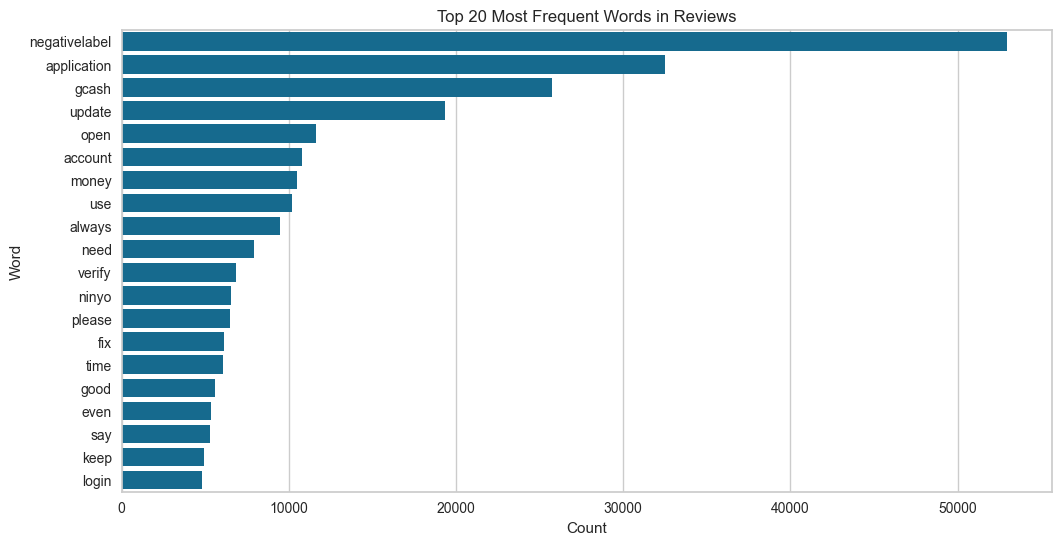

In [49]:
top_words = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=top_words)
plt.title("Top 20 Most Frequent Words in Reviews")
plt.show()


Distribution of Review Lengths

In [50]:
df['text_length'] = df['review_text_formatted'].apply(lambda x: len(x.split()))
print(df['text_length'].describe())  # Summary stats

count    75492.000000
mean        11.029924
std          9.236192
min          3.000000
25%          5.000000
50%          8.000000
75%         14.000000
max         84.000000
Name: text_length, dtype: float64


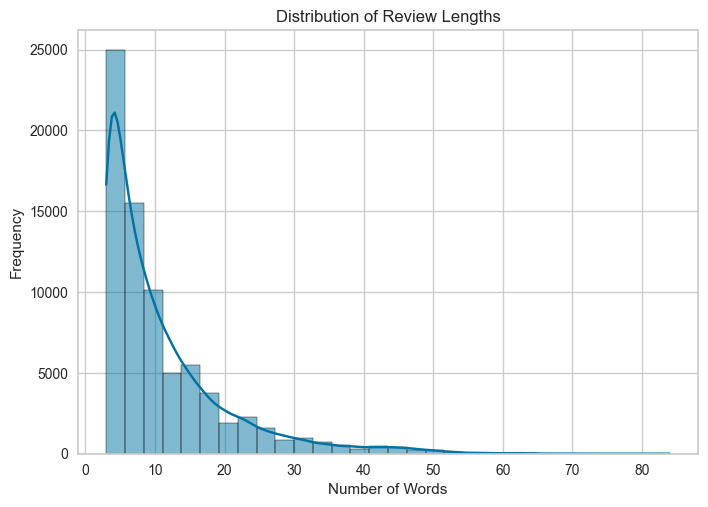

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['text_length'], bins=30, kde=True)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

df.drop(columns=['text_length'], inplace=True)

# Feature Representation

In [52]:
df.head()

,review_rating,review_likes,review_text_formatted
0,1,0,open gcash get choose late try gcash icon auto...
1,1,0,stupid application use original psa tell verif...
2,1,0,application keep disappearing
3,5,0,good negativelabel download anymore
4,1,0,palagi nawawala phone alam


In [53]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
X = vectorizer.fit_transform(df['review_text_formatted']).toarray()

In [54]:
df_tfidf = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())
print(df_tfidf)

       100x  10th  10x  11th  1gb  1hour  1st  1star  1week  1yr  ...   yu  \
0       0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...  0.0   
1       0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...  0.0   
2       0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...  0.0   
3       0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...  0.0   
4       0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...  0.0   
...     ...   ...  ...   ...  ...    ...  ...    ...    ...  ...  ...  ...   
75487   0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...  0.0   
75488   0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...  0.0   
75489   0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...  0.0   
75490   0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...  0.0   
75491   0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...  0.0   

       yuck  yumayaman  yun  yunh   yw  ywa  zero  zoloz  zzz  

In [55]:
print(f"Original DataFrame shape: {df.shape}")
print(f"TF-IDF matrix shape: {X.shape}")

Original DataFrame shape: (75492, 3)
TF-IDF matrix shape: (75492, 5644)


In [56]:
df = pd.concat([df, df_tfidf], axis=1)

In [57]:
df.head()

,review_rating,review_likes,review_text_formatted,100x,10th,10x,11th,1gb,1hour,1st,...,yu,yuck,yumayaman,yun,yunh,yw,ywa,zero,zoloz,zzz
0,1.0,0.0,open gcash get choose late try gcash icon auto...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,stupid application use original psa tell verif...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,application keep disappearing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.0,0.0,good negativelabel download anymore,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,palagi nawawala phone alam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Principal Component Analysis

In [58]:
df.drop(columns=['review_text_formatted', 'review_likes', 'review_rating'], inplace=True)

In [59]:
df.head()

,100x,10th,10x,11th,1gb,1hour,1st,1star,1week,1yr,...,yu,yuck,yumayaman,yun,yunh,yw,ywa,zero,zoloz,zzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
print(df.isna().sum())

100x     5310
10th     5310
10x      5310
11th     5310
1gb      5310
         ... 
yw       5310
ywa      5310
zero     5310
zoloz    5310
zzz      5310
Length: 5644, dtype: int64


In [61]:
df.dropna(inplace=True)
print(df.isna().sum())

100x     0
10th     0
10x      0
11th     0
1gb      0
        ..
yw       0
ywa      0
zero     0
zoloz    0
zzz      0
Length: 5644, dtype: int64


In [62]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000)  # Try 300 first
X_svd = svd.fit_transform(df)  # X is your TF-IDF matrix

print("Original shape:", df.shape)
print("Reduced shape:", X_svd.shape)

Original shape: (75492, 5644)
Reduced shape: (75492, 1000)


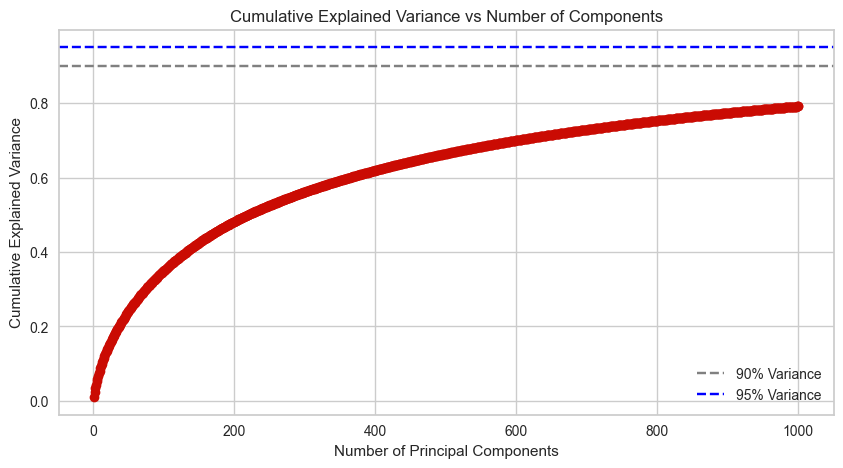

In [63]:
explained_variance = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 1001), cumulative_variance, marker='o', linestyle='-', color='r')

# Add Threshold Lines
plt.axhline(y=0.90, color='gray', linestyle='--', label='90% Variance')
plt.axhline(y=0.95, color='blue', linestyle='--', label='95% Variance')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.legend()
plt.grid(True)

plt.show()

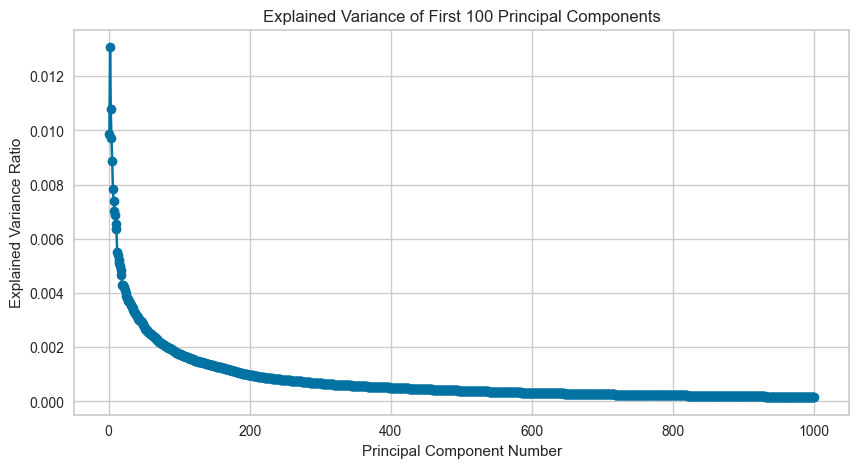

In [64]:
explained_variance = svd.explained_variance_ratio_

plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 1001), explained_variance, marker='o', linestyle='-', color='b')

plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance of First 100 Principal Components')
plt.grid(True)

plt.show()

In [65]:
# #Final n_components
# pca = PCA(n_components=20)
# X_reduced = pca.fit_transform(X)

# print("Original shape:", X.shape)
# print("Reduced shape:", X_reduced.shape)

In [66]:
# explained_variance = pca.explained_variance_ratio_

# plt.figure(figsize=(10, 5))
# plt.plot(np.arange(1, 21), explained_variance, marker='o', linestyle='-', color='b')

# plt.xlabel('Principal Component Number')
# plt.ylabel('Explained Variance Ratio')
# plt.title('Explained Variance of First 100 Principal Components')
# plt.grid(True)

# plt.show()

# Clustering

Elbow Method to determine the number of clusters to be formed:


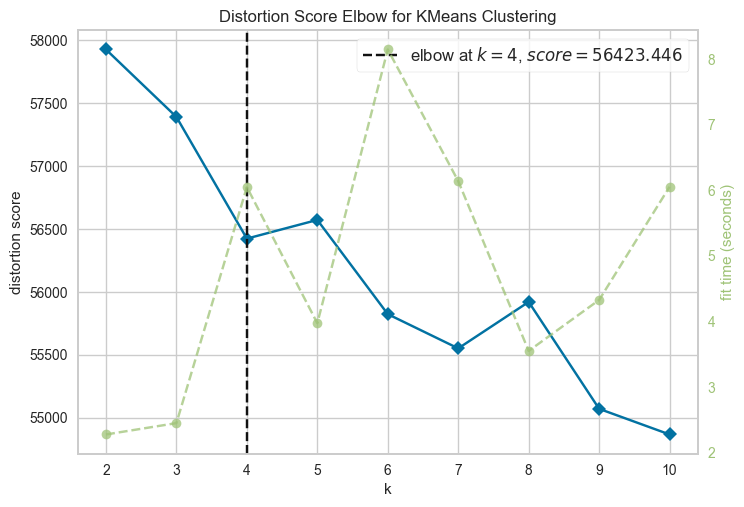

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [67]:
from yellowbrick.cluster import KElbowVisualizer

print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(max_iter=100, n_init='auto', init='k-means++'), k=10)
Elbow_M.fit(X_svd)
Elbow_M.show()

In [79]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

df['cluster'] = kmeans.fit_predict(X_svd)

In [80]:
from sklearn import metrics

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_svd, kmeans.labels_, sample_size=1000))

Silhouette Coefficient: 0.010


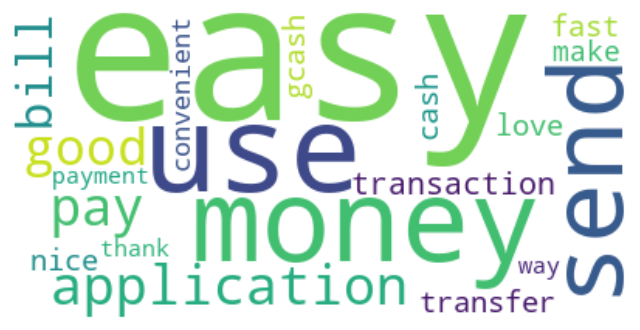

{'easy': np.float64(0.3987485215131456), 'use': np.float64(0.10063933171838892), 'money': np.float64(0.08924939299991584), 'send': np.float64(0.06823513291200214), 'application': np.float64(0.054476874285028044), 'pay': np.float64(0.05071348855645355), 'good': np.float64(0.04823918695059659), 'bill': np.float64(0.041955098224210306), 'transaction': np.float64(0.03923230556143247), 'transfer': np.float64(0.03670901419039058), 'nice': np.float64(0.0365372127236413), 'fast': np.float64(0.03479266443573644), 'love': np.float64(0.03464298961031877), 'cash': np.float64(0.033945116827099026), 'gcash': np.float64(0.032296053681296163), 'make': np.float64(0.029595997757655142), 'convenient': np.float64(0.02498108251858677), 'payment': np.float64(0.020890240083681115), 'way': np.float64(0.01971246544282964), 'thank': np.float64(0.01944747004439168)}


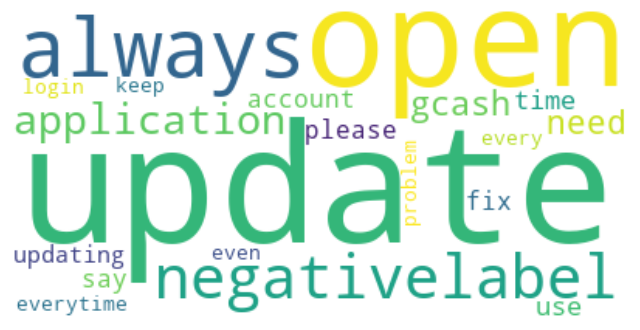

{'update': np.float64(0.12284735751667863), 'open': np.float64(0.12180790603428816), 'always': np.float64(0.10577708521014602), 'negativelabel': np.float64(0.10462338902441852), 'application': np.float64(0.0914478737617635), 'gcash': np.float64(0.058593510364286255), 'need': np.float64(0.053652397932875975), 'use': np.float64(0.032954711025574596), 'time': np.float64(0.032851789923678494), 'say': np.float64(0.03079544694172887), 'account': np.float64(0.03001568209192872), 'fix': np.float64(0.02929464264464267), 'please': np.float64(0.029145591511953395), 'updating': np.float64(0.02910101122395452), 'everytime': np.float64(0.02238178345634103), 'even': np.float64(0.022381501623053385), 'keep': np.float64(0.022121677131485676), 'login': np.float64(0.02134136722529937), 'every': np.float64(0.021085510881409947), 'problem': np.float64(0.01973112070098653)}


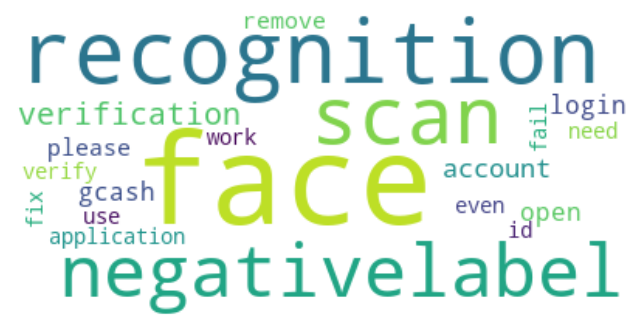

{'face': np.float64(0.3097784338621157), 'recognition': np.float64(0.12350039952593886), 'scan': np.float64(0.10232306367199129), 'negativelabel': np.float64(0.08759440009842138), 'verification': np.float64(0.0677523639277406), 'account': np.float64(0.04882064875808706), 'login': np.float64(0.043907998405846686), 'open': np.float64(0.043286511043584025), 'gcash': np.float64(0.04088460980705294), 'please': np.float64(0.03395674151058061), 'remove': np.float64(0.03276890899128567), 'work': np.float64(0.027732236302864168), 'need': np.float64(0.027421933131967436), 'verify': np.float64(0.026234800085435845), 'id': np.float64(0.026193570209324786), 'fix': np.float64(0.025499870510552452), 'application': np.float64(0.025036203026615293), 'use': np.float64(0.02477040838988276), 'fail': np.float64(0.02340022688096124), 'even': np.float64(0.023285254419420184)}


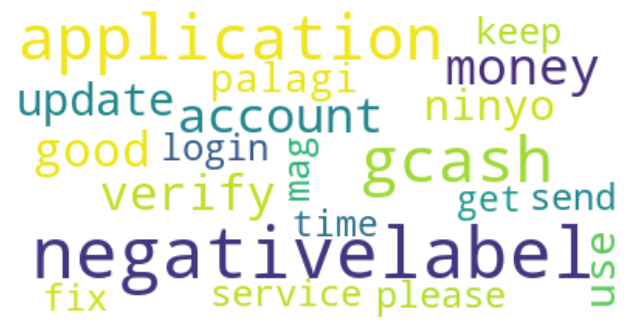

{'negativelabel': np.float64(0.05598729121493466), 'application': np.float64(0.04336250247503597), 'gcash': np.float64(0.043313904302429214), 'money': np.float64(0.025763808860095216), 'account': np.float64(0.023748994054745558), 'verify': np.float64(0.02241299199518187), 'good': np.float64(0.021993574493278715), 'update': np.float64(0.01974481877157047), 'use': np.float64(0.018686896870951066), 'ninyo': np.float64(0.018024390785044156), 'palagi': np.float64(0.015994573173065445), 'please': np.float64(0.014075831512188568), 'login': np.float64(0.013551699335830836), 'send': np.float64(0.013457280578291866), 'fix': np.float64(0.013392440976117428), 'mag': np.float64(0.013329223081770725), 'keep': np.float64(0.013175881186899226), 'service': np.float64(0.013133080892605557), 'get': np.float64(0.01156576803938279), 'time': np.float64(0.01132487075404669)}


In [81]:
# Get original feature names (words)
from wordcloud import WordCloud

terms = vectorizer.get_feature_names_out()

# Inverse transform cluster centers back to TF-IDF space
approx_tfidf = svd.inverse_transform(kmeans.cluster_centers_)

def frequencies_dict(cluster_index):
    if cluster_index >= num_clusters:
        return None
    
    term_frequencies = approx_tfidf[cluster_index]
    
    # Get top 20 words in this cluster
    sorted_indices = np.argsort(term_frequencies)[::-1][:20]
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_indices}
    
    return frequencies

def makeImage(frequencies):
    wc = WordCloud(background_color="white", max_words=50)
    wc.generate_from_frequencies(frequencies)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

for i in range(num_clusters):
    freq = frequencies_dict(i)
    if freq:
        makeImage(freq)
        print(freq)  # Optional: Print words with weights

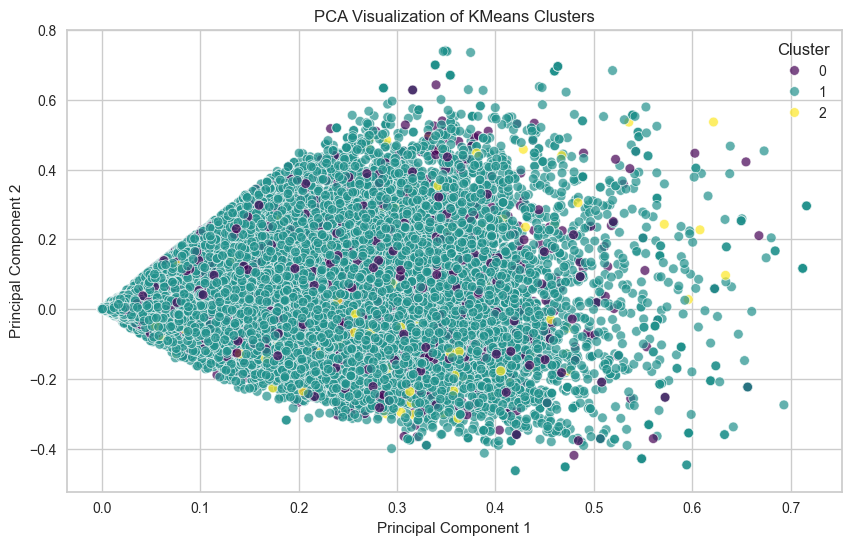

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to DataFrame with only first two components
df_pca = pd.DataFrame(X_svd[:, :2], columns=['PC1', 'PC2'])
df_pca['cluster'] = df['cluster']  # Assign KMeans cluster labels

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', palette='viridis', data=df_pca, alpha=0.7)
plt.title("PCA Visualization of KMeans Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.show()


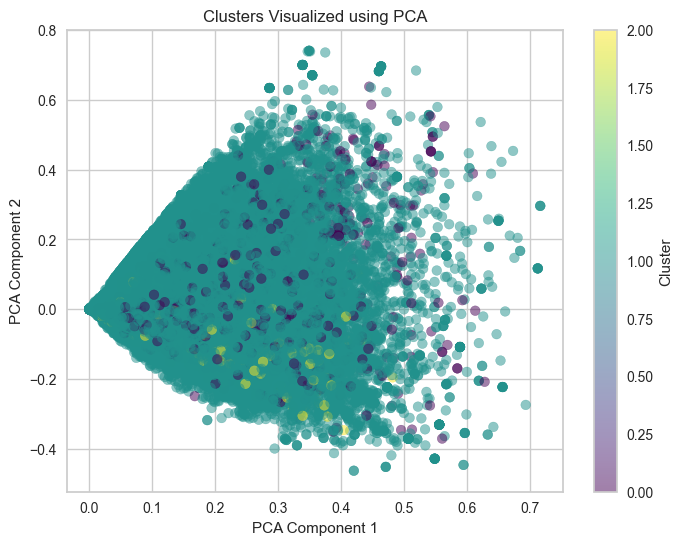

In [72]:
plt.figure(figsize=(8,6))
plt.scatter(X_svd[:,0], X_svd[:,1], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.colorbar(label="Cluster")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clusters Visualized using PCA")
plt.show()